# Active Learning for Level Set Estimation of Black Box functions

Talk for [PyHEP2021](https://indico.cern.ch/event/1019958/) by [Irina Espejo](https://irinaespejo.github.io/)

Work by [Lukas Heinrich](http://www.lukasheinrich.com/), [Gilles Louppe](https://glouppe.github.io/), [Irina Espejo](https://irinaespejo.github.io/), [Patrick Rieck](https://inspirehep.net/authors/1078568) and [Kyle Cranmer](http://theoryandpractice.org/)

<img src="../assets/thankyou.jpg" alt="Coauthors" title="Co-authors" width="550" height="300" class="center" />

## TOC
* [1. What is this about?](#1)
* [2. Setting of the problem](#2)
* [3. Specify the Gaussian Process prior](#3)
* * [3.1. Casual user](#3.1)
* * [3.2. Advanced](#3.2)
* [4. Initialize excursion](#4)
* [5. Active Learning](#5)
* [6. 2D example](#2d)
* [7. 4D example](#4d)


## 1. What is this about and why do I care? <a class="anchor" id="1"></a>

- We care because this <bottom arrow> type of plot is the end step of a HEP experimental analysis. 
  They are also incredibly expensive to produce, evaluating each point has high latency of days or weeks.
  
  <img src="../assets/ATLAS_contour.png" alt="Contour" title="A typical exclusion plot for a HEP analysis" width="400" height="400" class="center" />


- What can we do to scale this process up? This tutorial shows how to use `excursion`. It implements Active Learning with Gaussian Process Regression.
  
  <img src="../assets/idea.png" alt="Idea" title="Idea behind Excursion" width="650" height="200" class="center" />

with [GPytorch](https://gpytorch.ai/) support

## 2. Setting of the problem <a class="anchor" id="2"></a>

<div class="alert alert-block alert-info">

We have a black box function $f_{BB}(\theta): \mathbb{R}^d \rightarrow \mathbb{R}$ and a threshold $t \in \mathbb{R}$. 

Each evaluation $f_{BB}(\theta_0)$ takes a long long time to process.

We want to find the level set $E_t(f_{BB}) = \{ \theta \in \mathbb{R}^d | f_{BB}(\theta) = t\}$

with as few queries to $f_{BB}$ as possible

</div>

Let's start with a 1D example to have better visualizations. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore')

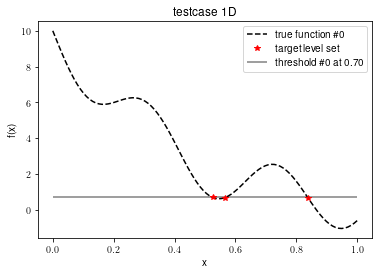

In [2]:
# import testcase 
import excursion
import excursion.testcases.fast_1D as testcase_1d

#plot testcase 
from excursion.plotting import plot_testcase_1d
plot_testcase_1d(testcase_1d, tol=0.05)

## 3. Specify the Gaussian Process prior

We use a Gaussian Process as a surrogate model for the Black Box function.
Gaussian Processes are non-parametric models where inductive bias is specified by the choice of mean and kernel. The observational model is specified by the likelihood.
GPyTorch has support for these [means](https://docs.gpytorch.ai/en/stable/means.html), [kernels](https://docs.gpytorch.ai/en/stable/kernels.html), [likelihoods](https://docs.gpytorch.ai/en/stable/models.html) and [inference models](https://docs.gpytorch.ai/en/stable/models.html)

We will use a constant mean, an RBF kernel $k(X, X') = C \exp{\left( -\frac{|| X-X' ||^2}{2l^2} \right)}$ and Exact Inference (no noise is added to the Black Box observation)

We anticipate two types of users:

    - Casual user for out-of-the-box usage and small tweaks
  
    - Advanced user who wants to have full control of all the moving parts _without_ messing with source code

### 3.1 Casual user

In [3]:
#load pre-existent algorithm options
import yaml
import json
file = open('../excursion/testcases/algorithms/algorithm_specs.yaml', "r")
algorithm_opts = yaml.safe_load(file)

In [4]:
#is there GPU?
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#initialize likelihood and GP with out-of-the-box options selected before
from excursion import init_gp
models, likelihood = init_gp(testcase_1d,             \
                             algorithm_opts,          \
                             device)

X_init  tensor([0.1717, 0.8081], dtype=torch.float64)
y_init  [tensor([5.8904, 1.4052], dtype=torch.float64)]


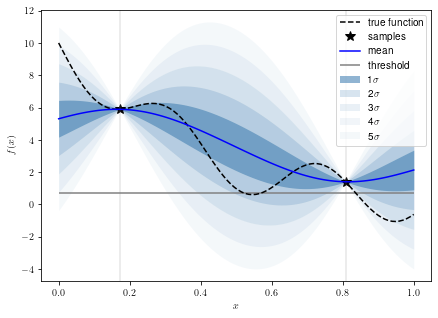

In [5]:
#plot gaussian process initialization
import excursion.plotting.onedim as plots
model = models[0]
plots.plot_GP(model, testcase_1d)

### 3.2 Advanced user

In [6]:
# FOR REFERENCE ONLY
# we will use the out of the box approach for the PyHEP21 tutorial
'''
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#initialize likelihood and GP
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# fit hyperparameters
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

#plot gaussian process initialization
import excursion.plotting.onedim as plots
plots.plot_GP(model, testcase_1d)
'''

'\nimport gpytorch\n\nclass ExactGPModel(gpytorch.models.ExactGP):\n    def __init__(self, train_x, train_y, likelihood):\n        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)\n        self.mean_module = gpytorch.means.ConstantMean()\n        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())\n\n    def forward(self, x):\n        mean_x = self.mean_module(x)\n        covar_x = self.covar_module(x)\n        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)\n\n#initialize likelihood and GP\nlikelihood = gpytorch.likelihoods.GaussianLikelihood()\nmodel = ExactGPModel(train_x, train_y, likelihood)\n\n# fit hyperparameters\nmodel.train()\nlikelihood.train()\nexcursion.fit_hyperparams(model,likelihood)\n\n#plot gaussian process initialization\nimport excursion.plotting.onedim as plots\nplots.plot_GP(model, testcase_1d)\n'

## 4. Initialize  Excursion Set Estimator <a class="anchor" id="4"></a>

The `ExcursionSetExtimator()`  object keeps internal track of the status of the Level Set Estimation.

For instance, stores the "next evaluation" suggestions, queries the black box and updates the Gaussian Process posterior.

In [7]:
from excursion import ExcursionSetEstimator
estimator = ExcursionSetEstimator(testcase_1d,    \
                                  algorithm_opts, \
                                  models,         \
                                  likelihood,     \
                                  device)

## 5. Active Learning <a class="anchor" id="5"></a>

Now we will find which is the next point to query through the black box function.

In [8]:
import os 
import datetime

#save results in folder
n_updates = algorithm_opts['nupdates']
timestampStr = datetime.datetime.now().strftime("%d-%b-%Y_%H:%M:%S") + "/"
outputfolder = "../examples/results/" +  timestampStr
os.makedirs(outputfolder)

In [9]:
%%capture wontshutup --no-stderr

for iteration in range(1, n_updates+1):    
    #take a step forward: find new points to evaluate
    estimator.step(testcase_1d, algorithm_opts, models, likelihood)
    #plot the new status
    estimator.plot_status(
            testcase_1d, algorithm_opts, models, estimator.acq_values, outputfolder);
    
    #update the posterior of the GP wrt the new points
    models = estimator.update_posterior(testcase_1d, algorithm_opts, models, likelihood)
    
    #get diagnostics (accuracy metric)
    estimator.get_diagnostics(testcase_1d, models, likelihood)
    
#save results
estimator.print_results(outputfolder, testcase_1d, algorithm_opts)


In [10]:
print(wontshutup)

Iteration  1
x_new 0.960
pct  0.94
Iteration  2
x_new 0.848
pct  0.95
Iteration  3
x_new 0.000
pct  0.95
Iteration  4
x_new 0.394
pct  0.95
Iteration  5
x_new 0.010
pct  0.95
Iteration  6
x_new 0.020
pct  0.95
Iteration  7
x_new 0.545
pct  1.0
Iteration  8
x_new 0.525
pct  1.0
Iteration  9
x_new 0.030
pct  1.0
Iteration  10
x_new 0.040
pct  1.0
Printing results...



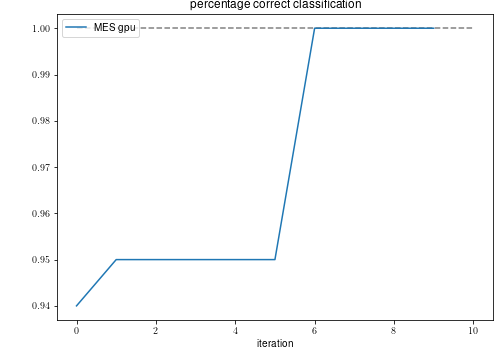

In [11]:
#print accuracy plot
from IPython.display import Image
filename=f"{os.getcwd()}/results/{timestampStr}/pct_correct_MES gpu_random.png"
Image(filename) 


In [12]:
#Let's visualize each iteration with a widget
import ipywidgets as widgets
from IPython.display import display
from IPython.html.widgets import interact
from natsort import natsorted

#load images
path = f"{os.getcwd()}/results/{timestampStr}"
imgs = list(filter(lambda fn:fn.startswith('1D'), os.listdir(path)))
imgs = natsorted(imgs, key=lambda y: y.lower())
def loadimg(k):
    display(Image(open(os.path.join(path,imgs[k]),'rb').read()))

#slider
w = widgets.IntSlider(
    min=0,
    max=len(imgs)-1,
    step=1,
    description='Iteration ',
    value=0
)
interact(loadimg, k = w);

interactive(children=(IntSlider(value=0, description='Iteration ', max=9), Output()), _dom_classes=('widget-in…

End of the 1D tutorial!

## 2D example <a class="anchor" id="2d"></a>

The package also ofers simultaneous level set estimation for two different functions. 
Note that the more similar the functions are, the less iterations are necessary to estimate all level sets.
With the exact same procedure as described above but in 2 dimensions we can achieve:


<img src="../assets/2d_pyhep.gif" alt="gif" title="2D animation" width="1300" height="400" class="center" />

## 7. 4D example <a class="anchor" id="7"></a>